In [111]:
import pandas
import matplotlib.pyplot as mat
import seaborn
import numpy 
from matplotlib.gridspec import GridSpec as grid
from matplotlib.ticker import MultipleLocator as ml

In [112]:
# Importing data
data = pandas.read_csv(r"C:\Users\Bhavik Parmar\OneDrive\Desktop\Data\Shoppers_Behaviour_and_Revenue.csv")

# Exploratory Data Analysis

In [113]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

### Insights:
Missing Data -> Null
Bool -> 2
Object (Str) -> 2
Int and Float -> 7 and 7 respectively

### Explor some Stastical Data

In [114]:
data.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


## Feature Engineering

In [115]:
data.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue'],
      dtype='object')

In [116]:
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [117]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [118]:
avgExitRate = data['ExitRates'].mean()
avgExitRate

np.float64(0.04307279776650446)

In [119]:
# Common Def Function Creation Cell ---> a window to have all the functions used in this whole session

def apply_isBounce(row):
    if (row['BounceRates'] == 1) & (row['ProductRelated'] == 1) & (row['ExitRates'] == 1):
        return 'Yes'
    elif (row['BounceRates'] != 1) & (row['ProductRelated'] != 1) & (row['ExitRates'] != 1):
        return 'No'
    else:
        return 'MayBe'
    
def apply_isExistedReally(row, avgExitRate):

    if row['ExitRates'] > avgExitRate:
        return 'Yes'
    else:
        return 'No'
    
def apply_hasLongSession(row, avgtotal):
    if row['totalDuration'] > avgtotal:
        return 'Yes'
    else:
        return 'No'

In [120]:
# Function for feature Engineering --> First function 


def first_engineering(data):

    # Basic Transformation of the columns    
    data['totalPagesViewed'] = data['Informational'] + data['Administrative'] + data['ProductRelated']
    
    data['totalDuration'] = data['Informational_Duration'] + data['Administrative_Duration'] + data['ProductRelated_Duration']
    
    data['avgTimePerPage'] = data['totalDuration'] / data['totalPagesViewed']

    return data
        

In [121]:
data1 = first_engineering(data = data) # Execution of the first function

In [122]:
# Second function for data engineering
def second_engineering(data):
    
    avgTotalDuration = data['totalDuration'].mean()
    data['hasLongSession'] = data.apply(lambda row: apply_hasLongSession(row, avgTotalDuration), axis=1)

    data['productFocus'] = data['ProductRelated'] / data['totalPagesViewed']

    data['productTimeRatio'] = data['ProductRelated_Duration'] / data['totalDuration']

    """Some Flag Based Columns (Categorical)"""
    # Whether They bounced ?
    avgExitRate = data['ExitRates'].mean()
    data['isBounce'] = data.apply(lambda row: apply_isBounce(row), axis=1)
    
    data['isExit'] = data.apply(lambda row: apply_isExistedReally(row, avgExitRate), axis=1)


    return data

In [123]:
data2 = second_engineering(data1)

In [124]:
def third_featureEngineering(data):
     
    # 1. Pages per Category Ratio
    data['adminPageRatio'] = data['Administrative'] / data['totalPagesViewed']
    data['infoPageRatio'] = data['Informational'] / data['totalPagesViewed']
    
    # 2. Time Distribution Ratios
    data['adminTimeRatio'] = data['Administrative_Duration'] / data['totalDuration']
    data['infoTimeRatio'] = data['Informational_Duration'] / data['totalDuration']
    
    # 3. Interaction Efficiency: Value per Page
    data['pageValuePerView'] = data['PageValues'] / (data['totalPagesViewed'] + 1e-6)
    
    # 4. Engagement Score (Custom metric combining duration, value, and low bounce rate)
    data['engagementScore'] = (
        (data['totalDuration'] / (data['totalDuration'].max() + 1e-6)) * 0.4 +
        (data['PageValues'] / (data['PageValues'].max() + 1e-6)) * 0.4 +
        ((1 - data['BounceRates']) / (1 + data['BounceRates'].max())) * 0.2
    )
    
    month_map = {
        'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'June': 6,
        'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
    }
    data['monthNum'] = data['Month'].map(month_map)
    
    def assign_season(m):
        if m in [12, 1, 2]: return 'Winter'
        elif m in [3, 4, 5]: return 'Spring'
        elif m in [6, 7, 8]: return 'Summer'
        else: return 'Fall'
    
    data['season'] = data['monthNum'].apply(assign_season)
    
    # 6. High Value Visitor Flag
    avg_page_value = data['PageValues'].mean()
    data['isHighValueVisitor'] = numpy.where(data['PageValues'] > avg_page_value, 'Yes', 'No')
    
    # 7. Time to Value Ratio
    data['timeToValueRatio'] = data['totalDuration'] / (data['PageValues'] + 1e-6)
    
    # 8. Weekend + High Engagement Interaction
    data['weekendHighEngagement'] = numpy.where(
        (data['Weekend'] == True) & (data['engagementScore'] > data['engagementScore'].mean()),
        'Yes', 'No'
    )

    return data

In [125]:
data = third_featureEngineering(data2)

In [126]:
# Removing some missing values ! 
haslongsessionMode = data['hasLongSession'].mode()[0]
data['hasLongSession']= data['hasLongSession'].fillna(haslongsessionMode)
productFocusMean = int(data['productFocus'].mean())
data.fillna(productFocusMean, inplace=True)

In [127]:
# Replacing Nann Values
data['productTimeRatio'] = data['productTimeRatio'].fillna(0)

## Exploratory Data Analysis ---> Continued

In [128]:
pandas.set_option('display.max_columns', None)
data.head(5)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,totalPagesViewed,totalDuration,avgTimePerPage,hasLongSession,productFocus,productTimeRatio,isBounce,isExit,adminPageRatio,infoPageRatio,adminTimeRatio,infoTimeRatio,pageValuePerView,engagementScore,monthNum,season,isHighValueVisitor,timeToValueRatio,weekendHighEngagement
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False,1,0.000000,0.000000,No,1.0,0.0,MayBe,Yes,0.0,0.0,0.0,0.0,0.0,0.133333,2,Winter,No,0.000000e+00,No
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False,2,64.000000,32.000000,No,1.0,1.0,No,Yes,0.0,0.0,0.0,0.0,0.0,0.167033,2,Winter,No,6.400000e+07,No
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False,1,0.000000,0.000000,No,1.0,0.0,MayBe,Yes,0.0,0.0,0.0,0.0,0.0,0.133333,2,Winter,No,0.000000e+00,No
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False,2,2.666667,1.333333,No,1.0,1.0,No,Yes,0.0,0.0,0.0,0.0,0.0,0.158349,2,Winter,No,2.666667e+06,No
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False,10,627.500000,62.750000,No,1.0,1.0,No,Yes,0.0,0.0,0.0,0.0,0.0,0.166923,2,Winter,No,6.275000e+08,No


count    12330.000000
mean        31.731468
std         44.475503
min          0.000000
25%          7.000000
50%         18.000000
75%         38.000000
max        705.000000
Name: ProductRelated, dtype: float64
Max Value 705


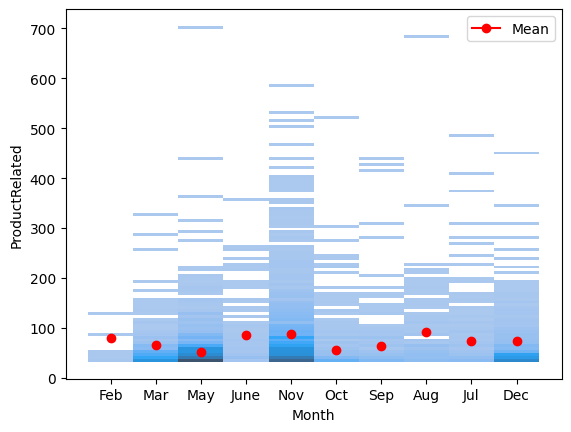

In [129]:
# Product Related 
overview = data['ProductRelated'].describe()
print(overview)
maxVal = data['ProductRelated'].max()
print('Max Value', maxVal)

# Product Page Visists
avg_val = data['ProductRelated'].mean()
specific = data.loc[data['ProductRelated'] > avg_val]

seaborn.histplot(y=specific['ProductRelated'], x=specific['Month'])

meanforEachday = specific.groupby('Month')['ProductRelated'].mean()
for i, month in enumerate(meanforEachday.index):
    mat.plot(i, meanforEachday[month], marker='o', color='red', label='Mean' if i == 0 else "")

mat.legend()
mat.show()

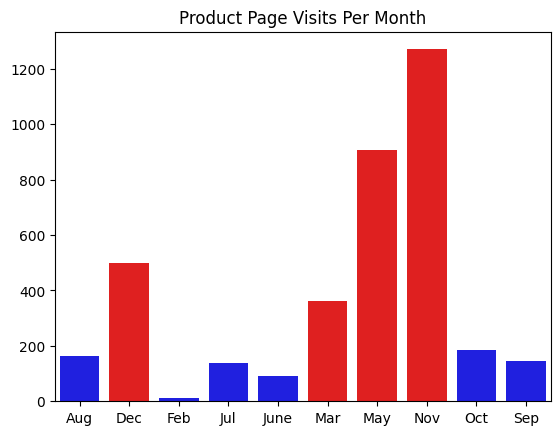

In [130]:
# Plotting countplot
countByMonths = specific.groupby('Month')['ProductRelated'].count()
pointer = 300
colorSeq = [ 'red' if val > pointer else 'blue' for val in countByMonths.values.tolist() ]

# Plotting count plot
seaborn.barplot(
    x = countByMonths.index.tolist(),
    y = countByMonths.values.tolist(),
    hue= countByMonths.index.tolist(),
    palette=colorSeq,
    legend=False
)
mat.title('Product Page Visits Per Month')
mat.show()

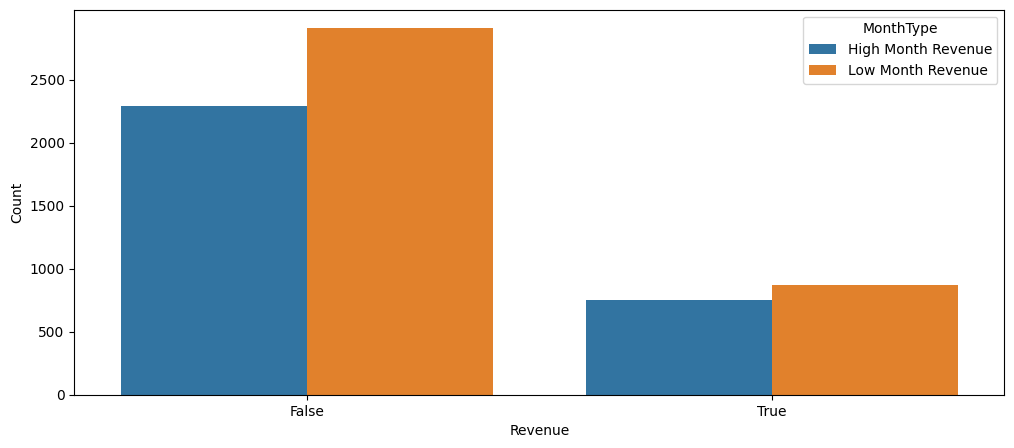

         High Month Revenue  Low Month Revenue
Revenue                                       
False                  2293               2910
True                    749                868


In [131]:
"""Grouping by revenue and months"""
# This is for the red bar (Months)
highMonthRevenue = specific.loc[
    (specific['Month'] == 'Dec') | (specific['Month'] == 'Mar') | (specific['Month'] == 'May') | (specific['Month'] == 'Nov') # Getting specific months
].groupby('Revenue')['ProductRelated'].count()

# This is for the remaning months
lowMonthRevenue = specific.loc[
    (specific['Month'] != 'Dec') | (specific['Month'] != 'Mar') | (specific['Month'] != 'May') | (specific['Month'] != 'Nov') # Getting specific months
].groupby('Revenue')['ProductRelated'].count()

# Creating dataframe
tempDataframe1 = pandas.DataFrame(
    pandas.concat(
        [highMonthRevenue.rename('High Month Revenue'),
        lowMonthRevenue.rename('Low Month Revenue')],
        axis=1)
)

tempDataframe1.index.name = 'Revenue'

newDf = tempDataframe1.reset_index().melt(
    id_vars='Revenue',             
    var_name='MonthType',          
    value_name='Count'       
)

mat.figure(figsize=(12, 5))

seaborn.barplot(
    x = newDf['Revenue'],
    y = newDf['Count'],
    hue = newDf['MonthType']
)

customAxis = [val for val in range(0, newDf['Count'].max(), 500)]
mat.yticks(customAxis)

mat.show()

print(tempDataframe1)

Text(0.5, 1.0, 'Revenue Generated Counts Per Month')

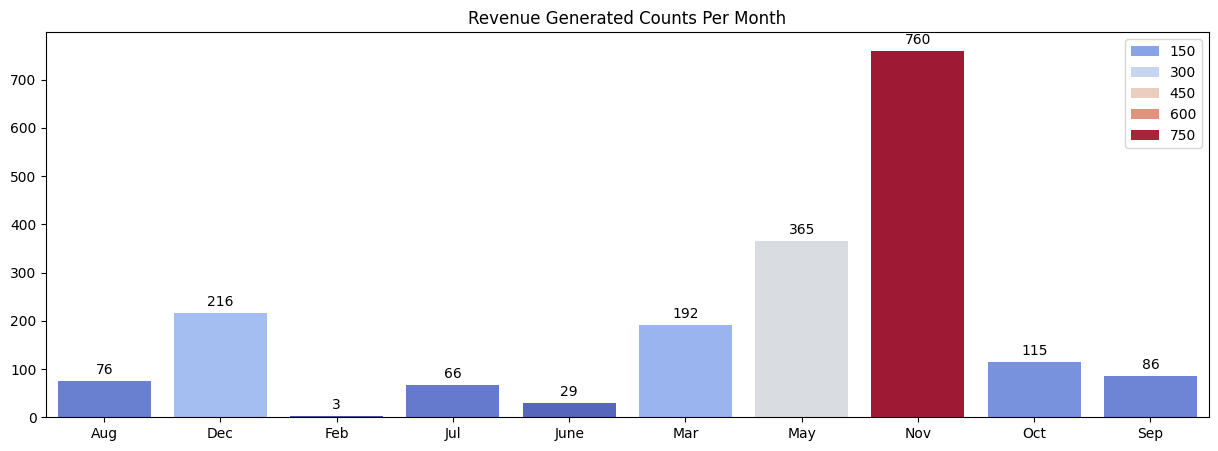

In [132]:
# Months where we generated the revenue (Full data)
RevenuebyMonth = data.loc[data['Revenue'] == True].groupby('Month')['Revenue'].count()

fig, ax = mat.subplots(1, 1, figsize=(15, 5))

bar = seaborn.barplot(
    x=RevenuebyMonth.index.tolist(),
    y = RevenuebyMonth.values.tolist(),
    hue = RevenuebyMonth.values.tolist(),
    palette='coolwarm',
    ax=ax
)

# Adding values to the plot ----> For better intution and interpretation
for labelsToTheBar in bar.containers:
    bar.bar_label(labelsToTheBar, fmt='%.0f', padding=3)

ax.set_title('Revenue Generated Counts Per Month')


In [133]:
# Way Changed!
pointfinder = data.loc[
    ((data['Month'] == 'Nov') | (data['Month'] == 'Dec') | (data['Month'] == 'Mar') | (data['Month'] == 'May')) & (data['Revenue'] == True)
]

nonrevenuecustomer = data.loc[
    ~(((data['Month'] == 'Nov') | (data['Month'] == 'Dec') | (data['Month'] == 'Mar') | (data['Month'] == 'May')) & (data['Revenue'] == True))
]

pointfinder

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,totalPagesViewed,totalDuration,avgTimePerPage,hasLongSession,productFocus,productTimeRatio,isBounce,isExit,adminPageRatio,infoPageRatio,adminTimeRatio,infoTimeRatio,pageValuePerView,engagementScore,monthNum,season,isHighValueVisitor,timeToValueRatio,weekendHighEngagement
188,9,111.500000,1,48.50,49,1868.819697,0.000000,0.020709,1.706015,0.0,Mar,2,2,7,2,Returning_Visitor,False,True,59,2028.819697,34.386775,Yes,0.830508,0.921136,No,No,0.152542,0.016949,0.054958,0.023906,0.028916,0.180159,3,Spring,No,1.189215e+03,No
196,2,56.000000,1,144.00,67,2563.783333,0.000000,0.005797,19.342650,0.0,Mar,2,2,4,2,New_Visitor,False,True,70,2763.783333,39.482619,Yes,0.957143,0.927635,No,No,0.028571,0.014286,0.020262,0.052102,0.276324,0.203864,3,Spring,Yes,1.428854e+02,No
198,0,0.000000,0,0.00,17,840.233333,0.000000,0.001667,109.176000,0.0,Mar,2,2,9,2,New_Visitor,False,True,17,840.233333,49.425490,No,1.000000,1.000000,No,No,0.000000,0.000000,0.000000,0.000000,6.422117,0.292189,3,Spring,Yes,7.696136e+00,No
199,3,94.000000,2,125.00,55,1970.844805,0.000000,0.001724,96.255116,0.0,Mar,2,4,1,2,New_Visitor,True,True,60,2189.844805,36.497413,Yes,0.916667,0.899993,No,No,0.050000,0.033333,0.042925,0.057082,1.604252,0.285623,3,Spring,Yes,2.275042e+01,Yes
200,1,32.000000,0,0.00,50,2867.000000,0.000000,0.004000,153.443248,0.0,Mar,2,2,7,8,Returning_Visitor,True,True,51,2899.000000,56.843137,Yes,0.980392,0.988962,No,No,0.019608,0.000000,0.011038,0.000000,3.008691,0.352912,3,Spring,Yes,1.889298e+01,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12272,6,133.466667,0,0.00,44,2664.445833,0.002041,0.010884,97.860836,0.0,Nov,2,2,1,3,Returning_Visitor,True,True,50,2797.912500,55.958250,Yes,0.880000,0.952298,No,No,0.120000,0.000000,0.047702,0.000000,1.957217,0.290537,11,Fall,Yes,2.859073e+01,Yes
12276,7,139.575000,0,0.00,30,986.500000,0.000000,0.011429,36.392861,0.0,Dec,2,10,1,2,New_Visitor,False,True,37,1126.075000,30.434459,No,0.810811,0.876052,No,No,0.189189,0.000000,0.123948,0.000000,0.983591,0.213348,12,Winter,Yes,3.094219e+01,No
12311,1,0.000000,2,211.25,144,4627.489571,0.001361,0.020664,0.000000,0.0,Nov,2,2,1,2,Returning_Visitor,False,True,147,4838.739571,32.916596,Yes,0.979592,0.956342,No,No,0.006803,0.013605,0.000000,0.043658,0.000000,0.194121,11,Fall,No,4.838740e+09,No
12312,7,150.357143,1,9.00,221,11431.001240,0.011149,0.021904,1.582473,0.0,Nov,2,5,1,2,Returning_Visitor,True,True,229,11590.358383,50.612919,Yes,0.965066,0.986251,No,No,0.030568,0.004367,0.012973,0.000777,0.006910,0.232863,11,Fall,No,7.324201e+03,Yes


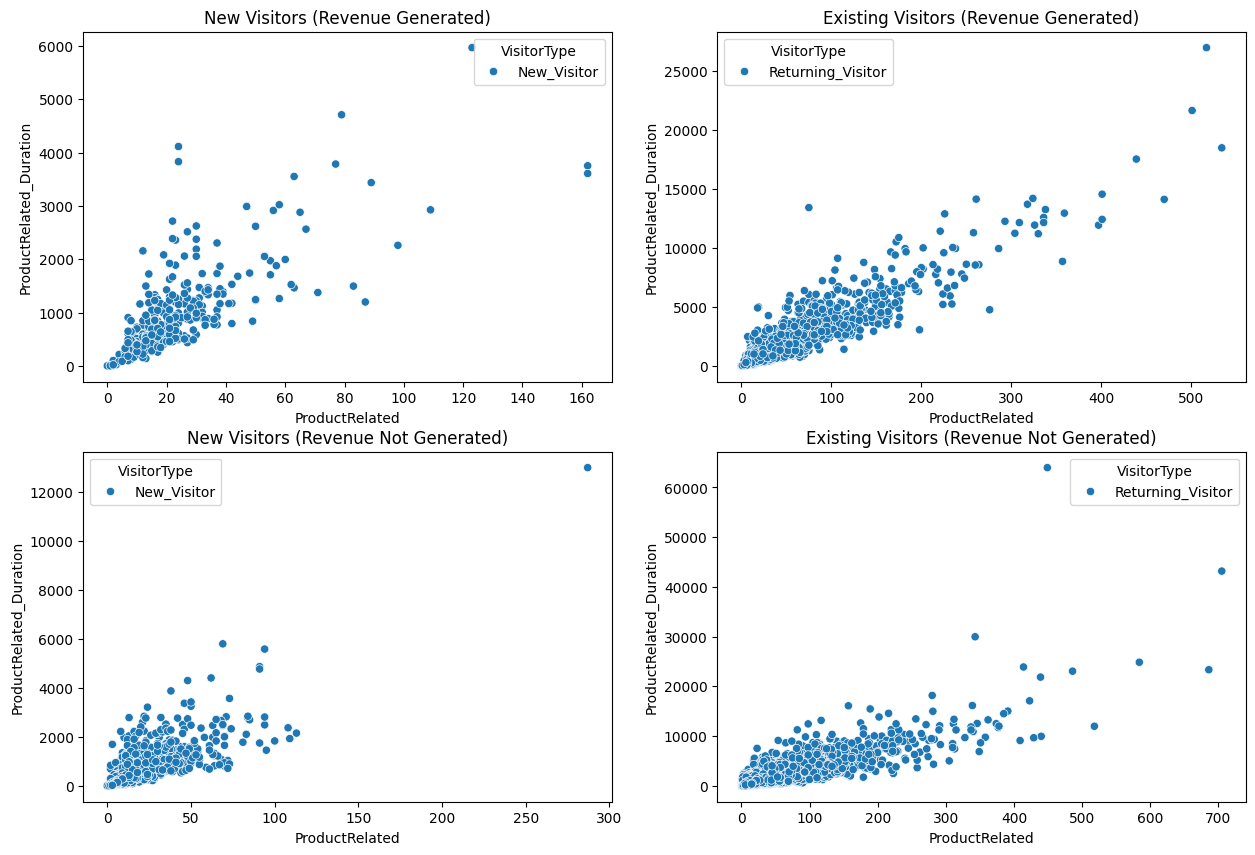

In [134]:
# Buyers and non-buyers behaviour -> Comparison

# Where the revenue was generated
newVisitor = pointfinder.loc[pointfinder['VisitorType'] == 'New_Visitor']
existingVisitor = pointfinder.loc[pointfinder['VisitorType'] == 'Returning_Visitor']

fig, ax = mat.subplots(2, 2, figsize=(15, 10))

seaborn.scatterplot(x = newVisitor['ProductRelated'], y = newVisitor['ProductRelated_Duration'], hue = newVisitor['VisitorType'], ax = ax[0, 0])
seaborn.scatterplot(x = existingVisitor['ProductRelated'], y = existingVisitor['ProductRelated_Duration'], hue = existingVisitor['VisitorType'], ax = ax[0, 1])

ax[0, 0].set_title('New Visitors (Revenue Generated)')
ax[0, 1].set_title('Existing Visitors (Revenue Generated)')

# Where the revenue was not generated
newVisitornon = nonrevenuecustomer.loc[nonrevenuecustomer['VisitorType'] == 'New_Visitor']
existingVisitornon = nonrevenuecustomer.loc[nonrevenuecustomer['VisitorType'] == 'Returning_Visitor']

seaborn.scatterplot(x = newVisitornon['ProductRelated'], y = newVisitornon['ProductRelated_Duration'], hue = newVisitornon['VisitorType'], ax = ax[1, 0])
seaborn.scatterplot(x = existingVisitornon['ProductRelated'], y = existingVisitornon['ProductRelated_Duration'], hue = existingVisitornon['VisitorType'], ax = ax[1, 1])

ax[1, 0].set_title('New Visitors (Revenue Not Generated)')
ax[1, 1].set_title('Existing Visitors (Revenue Not Generated)')

mat.show()

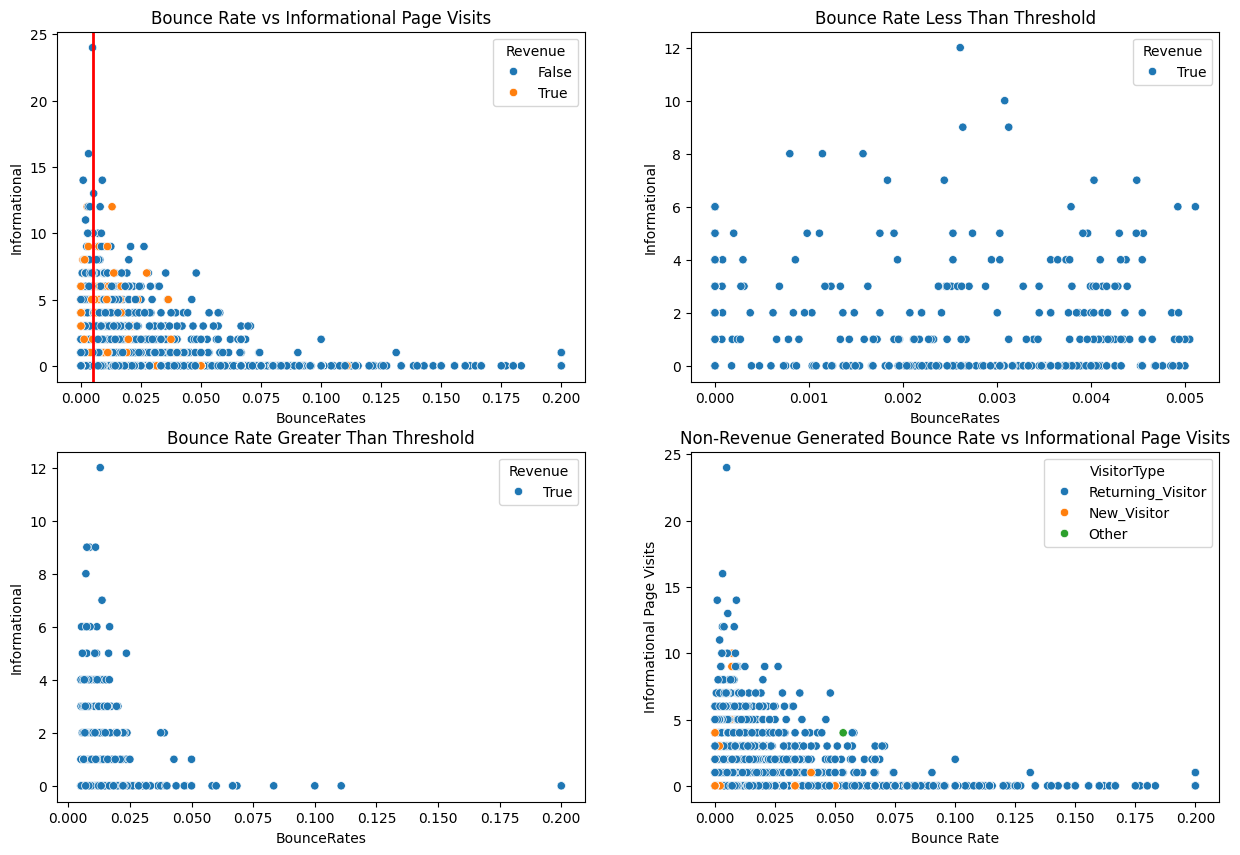

In [135]:
# Comparison between (bounce and exit rate) and (informational and page related visits)

bounceRateThreshold = data.loc[data['Revenue'] == True]['BounceRates'].mean()

# Considering the nonrevenue ones -> To have clear idea about non-buyers
fig, ax = mat.subplots(2, 2, figsize=(15, 10))

seaborn.scatterplot(
    x = data['BounceRates'], 
    y = data['Informational'],
    hue = data['Revenue'],
    ax = ax[0, 0]
)

ax[0, 0].axvline(x=bounceRateThreshold, color='red', linestyle='-', label='Bounce Rate Threshold', linewidth=2)
ax[0, 0].set_title('Bounce Rate vs Informational Page Visits')

# Presentation of the less than threshold ---> Who have purchased something
LessthenThreshold = pointfinder.loc[(data['BounceRates'] < bounceRateThreshold)]
seaborn.scatterplot(
    x = LessthenThreshold['BounceRates'], 
    y = LessthenThreshold['Informational'],
    hue= LessthenThreshold['Revenue'],
    ax = ax[0, 1]
)
ax[0, 1].set_title('Bounce Rate Less Than Threshold')

# Presentation of the greater than threshold ---> Who have purchased something
greaterthenThreshold = pointfinder.loc[~(data['BounceRates'] < bounceRateThreshold)]
seaborn.scatterplot(
    x = greaterthenThreshold['BounceRates'], 
    y = greaterthenThreshold['Informational'],
    hue = greaterthenThreshold['Revenue'],
    ax = ax[1, 0]
)
ax[1, 0].set_title('Bounce Rate Greater Than Threshold')

# Remaining Ones
remainingOnes = data.loc[data['Revenue'] == False]
seaborn.scatterplot(
    x = remainingOnes['BounceRates'], 
    y = remainingOnes['Informational'],
    hue= remainingOnes['VisitorType'],
    ax = ax[1, 1]
)
ax[1, 1].set_title('Non-Revenue Generated Bounce Rate vs Informational Page Visits')
ax[1, 1].set_xlabel('Bounce Rate')
ax[1, 1].set_ylabel('Informational Page Visits')
mat.show()

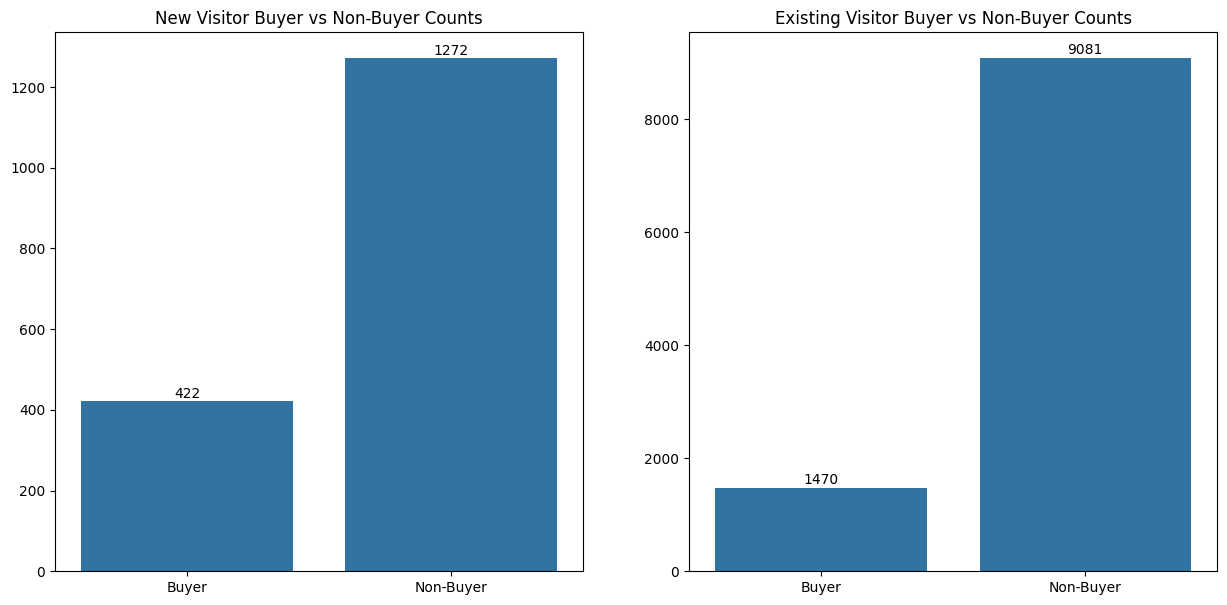

In [136]:
# Setting Canvas Figure
fig, ax = mat.subplots(1, 2, figsize=(15, 7))

# Insights on whether the new visitors are buyers or non-buyers
new_visitor_nonbuyer = data.loc[(data['VisitorType'] == 'New_Visitor') & (data['Revenue'] == False)]
new_visitor_buyer = data.loc[(data['VisitorType'] == 'New_Visitor') & (data['Revenue'] == True)]

# Plotting the counts --> New Visitors 
newVisitorCountData = [len(new_visitor_buyer), len(new_visitor_nonbuyer)] 
countPlot = seaborn.barplot(data = newVisitorCountData ,ax=ax[0])
countPlot.set_title('New Visitor Buyer vs Non-Buyer Counts')
countPlot.set_xticks([0, 1])
countPlot.set_xticklabels(['Buyer', 'Non-Buyer'])

# Adding numbers to the bars
for thelabels in countPlot.containers:
    countPlot.bar_label(thelabels, fmt='%.0f')

# Insights on whether the Existing purchased or not
exist_visitor_nonbuyer = data.loc[(data['VisitorType'] == 'Returning_Visitor') & (data['Revenue'] == False)]
exist_visitor_buyer = data.loc[(data['VisitorType'] == 'Returning_Visitor') & (data['Revenue'] == True)]

# Plotting the counts --> Existing Visitors
existing = [len(exist_visitor_buyer), len(exist_visitor_nonbuyer)]
colors = ['red', 'yellow'] 
countExisting = seaborn.barplot(data = existing, ax=ax[1])
countExisting.set_title('Existing Visitor Buyer vs Non-Buyer Counts')
countExisting.set_xticks([0, 1])
countExisting.set_xticklabels(['Buyer', 'Non-Buyer'])
for ExistingCountLabels in countExisting.containers:
    countExisting.bar_label(ExistingCountLabels, fmt='%.0f', padding=1)
mat.show()

# Insights
<span>Based on this analysis we can say that 67% new customers do not buy where as almost 83 percent existing customers do not buy from our website. only 13 percentage of our exisiting customer base like buy from our website</span>

Questions:
## Existing Customer
- What is that which is not letting them to buy the product ? Do they come here for a reason ? -> Page Presence (thus applicable to both the customer basis)

In [137]:
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,totalPagesViewed,totalDuration,avgTimePerPage,hasLongSession,productFocus,productTimeRatio,isBounce,isExit,adminPageRatio,infoPageRatio,adminTimeRatio,infoTimeRatio,pageValuePerView,engagementScore,monthNum,season,isHighValueVisitor,timeToValueRatio,weekendHighEngagement
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False,1,0.000000,0.000000,No,1.0,0.0,MayBe,Yes,0.0,0.0,0.0,0.0,0.0,0.133333,2,Winter,No,0.000000e+00,No
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False,2,64.000000,32.000000,No,1.0,1.0,No,Yes,0.0,0.0,0.0,0.0,0.0,0.167033,2,Winter,No,6.400000e+07,No
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False,1,0.000000,0.000000,No,1.0,0.0,MayBe,Yes,0.0,0.0,0.0,0.0,0.0,0.133333,2,Winter,No,0.000000e+00,No
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False,2,2.666667,1.333333,No,1.0,1.0,No,Yes,0.0,0.0,0.0,0.0,0.0,0.158349,2,Winter,No,2.666667e+06,No
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False,10,627.500000,62.750000,No,1.0,1.0,No,Yes,0.0,0.0,0.0,0.0,0.0,0.166923,2,Winter,No,6.275000e+08,No


## Why we have bad retension rate ?

In [138]:
# Data
badRetention = data.loc[(data['Revenue'] == False) & (data['VisitorType'] == 'Returning_Visitor')]
goodRetention = data.loc[(data['Revenue'] == True) & (data['VisitorType'] == 'Returning_Visitor')]

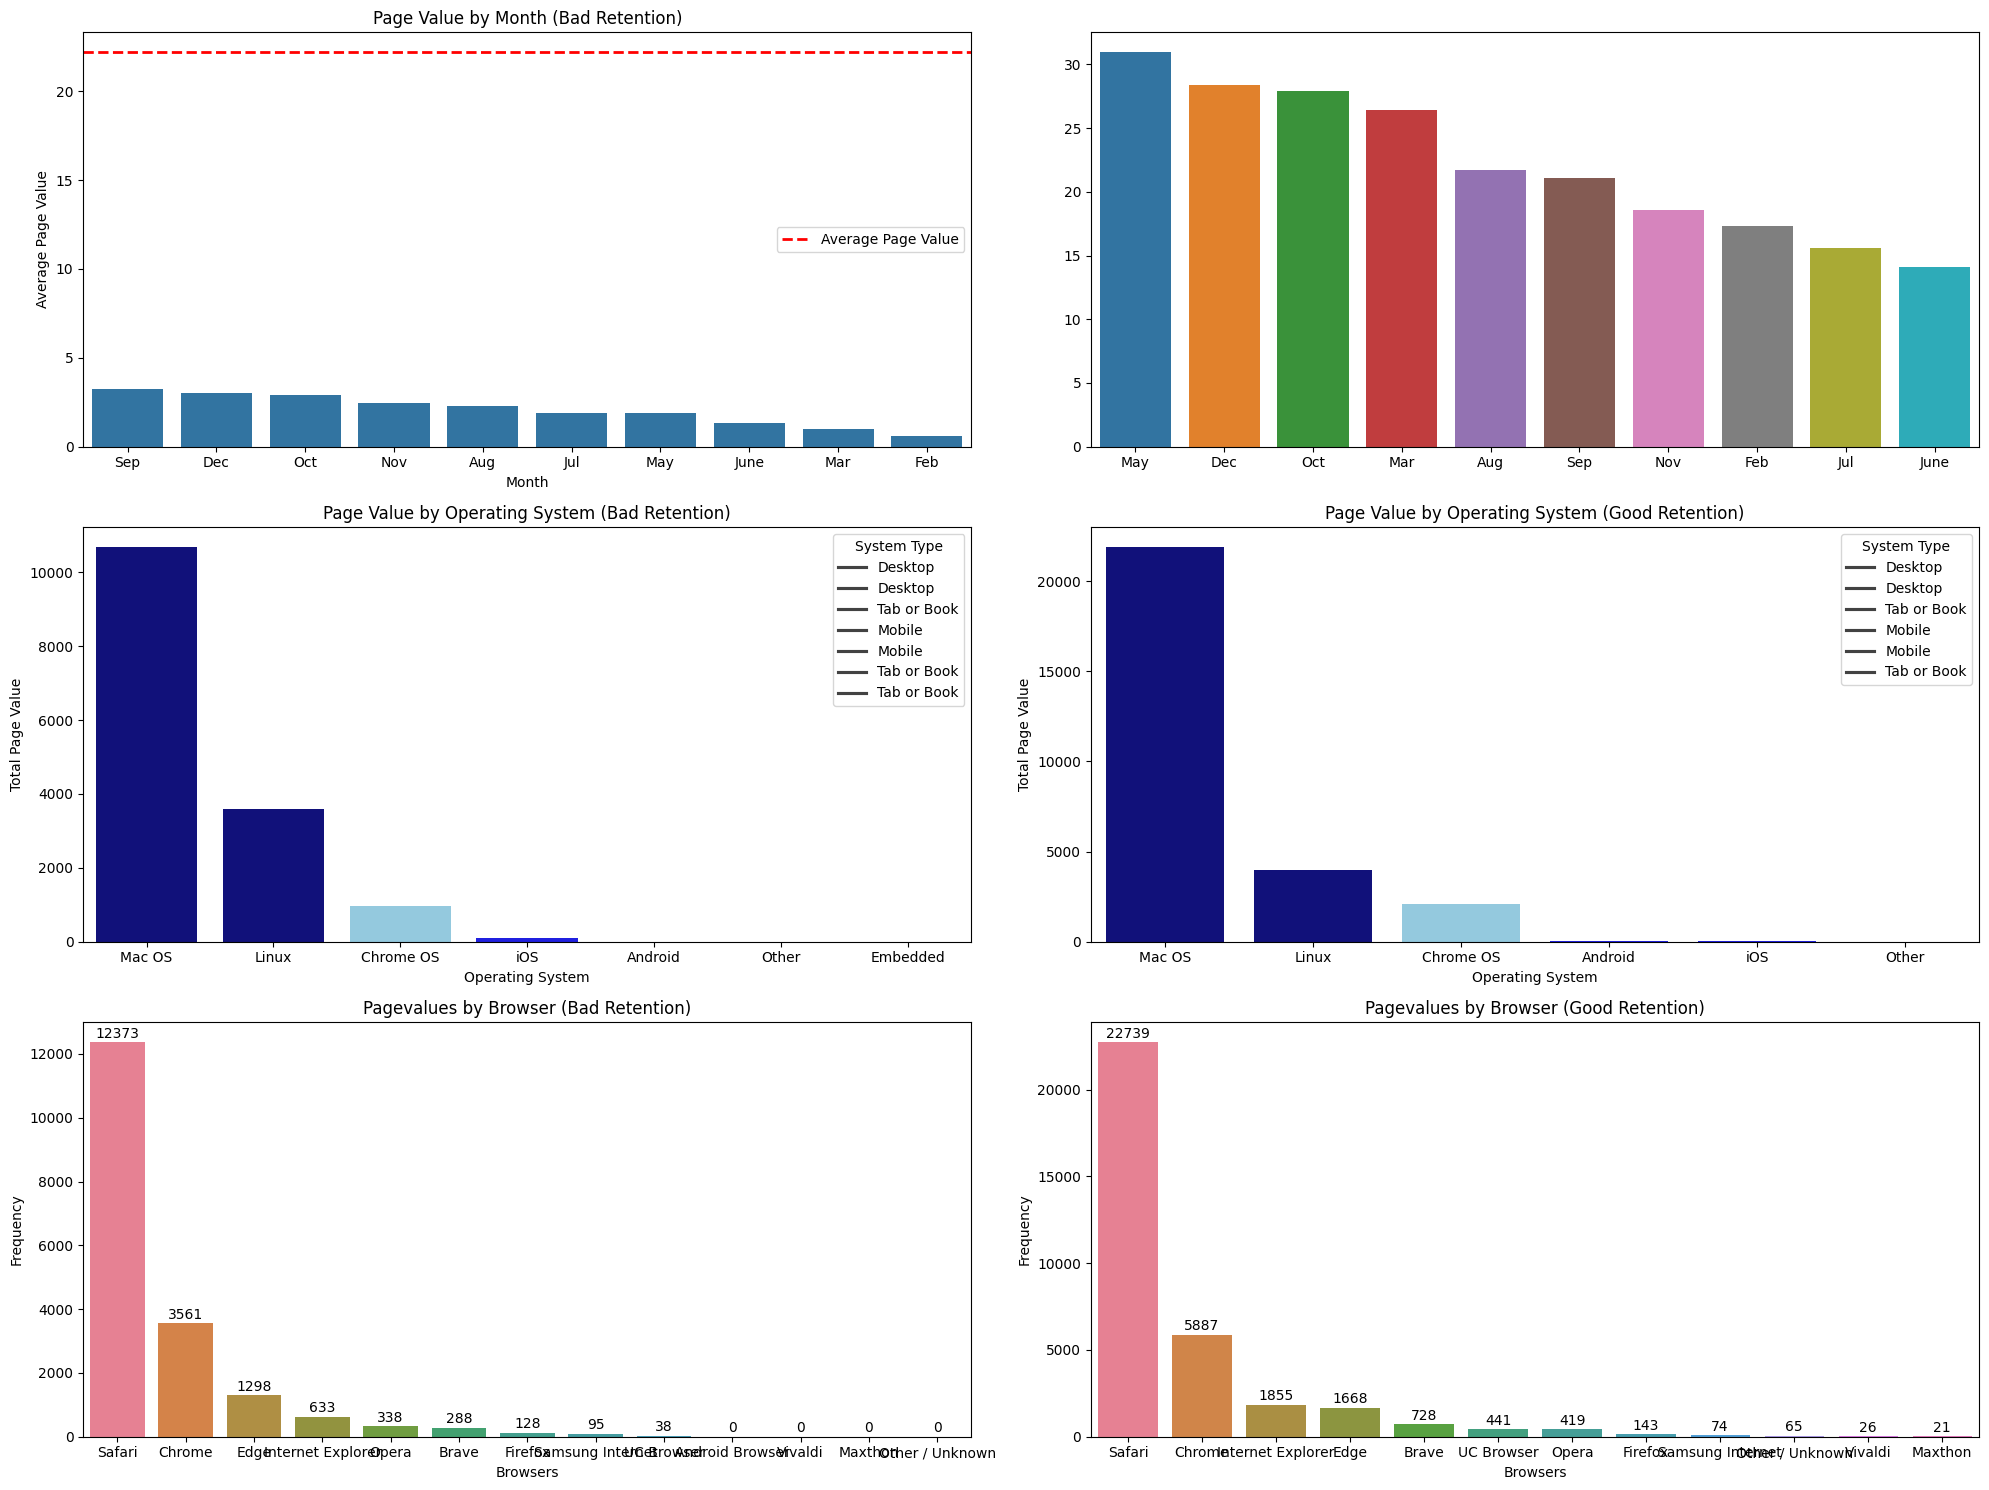

In [139]:
# Functions to be used in the plots
def apply_auto(array):

    # Plot settings -> For Bad Retention
    colors = []
    system = []
    
    # Subtraction is also hardcoded!
    for val in range(len(array) - 1): 
        if val == 0 or val == 1: # Values are hardcoded!
            colors.append('darkblue')
            system.append('Desktop')
        elif val == 3 or val == 4:
            colors.append('blue')
            system.append('Mobile')
        else:
            colors.append('skyblue')
            system.append('Tab or Book')
    
    return colors, system


# MONTH
# Exploring Page Value -> Who Purchased Something
fig, ax = mat.subplots(3, 2, figsize=(20, 15))

month_to_pagevalue = badRetention.groupby('Month')['PageValues'].mean().sort_values(ascending=False)
month_to_pagevalue_good = goodRetention.groupby('Month')['PageValues'].mean().sort_values(ascending=False)
pagevalue_mean = goodRetention.groupby('Month')['PageValues'].mean().sort_values(ascending=False).mean()

seaborn.barplot(
    x = month_to_pagevalue.index.tolist(),
    y = month_to_pagevalue.values.tolist(),
    ax=ax[0, 0]
)
ax[0, 0].axhline(y=pagevalue_mean, color='red', linestyle='--', label='Average Page Value', linewidth=2)
ax[0, 0].set_title('Page Value by Month (Bad Retention)')
ax[0, 0].set_xlabel('Month')
ax[0, 0].set_ylabel('Average Page Value')
ax[0, 0].legend()

# Page Value and its relation with total pages viewed
seaborn.barplot(
    x = month_to_pagevalue_good.index.tolist(), 
    y = month_to_pagevalue_good.values.tolist(), 
    hue = month_to_pagevalue_good.index.tolist(), 
    ax=ax[0, 1]
)


# Operating Systems
# Operating System and its relation with page value
os_pagevalue = badRetention.groupby('OperatingSystems')['PageValues'].sum().sort_values(ascending=False)
os_pagevalue_good = goodRetention.groupby('OperatingSystems')['PageValues'].sum().sort_values(ascending=False)

# Converting the values to text
os_map = {
    2: 'Mac OS',
    3: 'Linux',
    4: 'Chrome OS',
    5: 'Android',
    6: 'iOS',
    7: 'Other',
    8: 'Embedded'
} 

os_pagevalue.index = os_pagevalue.index.map(os_map) # Value Changed
clr1, syst1 = apply_auto(os_pagevalue) # Colors and System Type

os_pagevalue_good.index = os_pagevalue_good.index.map(os_map) # Value Changed
clr2, syst2 = apply_auto(os_pagevalue_good) # Colors and System Type

seaborn.barplot(
    x = os_pagevalue.index.tolist(),
    y = os_pagevalue.values.tolist(),
    ax=ax[1, 0],
    hue = os_pagevalue.index.tolist(),
    palette=clr1
)

ax[1, 0].set_title('Page Value by Operating System (Bad Retention)')
ax[1, 0].set_xlabel('Operating System')
ax[1, 0].set_ylabel('Total Page Value')
ax[1, 0].legend(title='System Type', labels=syst1)

seaborn.barplot(
    x = os_pagevalue_good.index.tolist(),
    y = os_pagevalue_good.values.tolist(),
    ax=ax[1, 1],
    hue = os_pagevalue_good.index.tolist(),
    palette=clr2
)
ax[1, 1].set_title('Page Value by Operating System (Good Retention)')
ax[1, 1].set_xlabel('Operating System')
ax[1, 1].set_ylabel('Total Page Value')
ax[1, 1].legend(title='System Type', labels=syst2)


# Browsers
browser_pagevalue = badRetention.groupby('Browser')['PageValues'].sum().sort_values(ascending=False)
browser_pagevalue_good = goodRetention.groupby('Browser')['PageValues'].sum().sort_values(ascending=False)

# Updating the values
browser_mapping = {
    1: 'Chrome',
    2: 'Safari',
    3: 'Firefox',
    4: 'Edge',
    5: 'Internet Explorer',
    6: 'Opera',
    7: 'Samsung Internet',
    8: 'UC Browser',
    9: 'Android Browser',
    10: 'Brave',
    11: 'Vivaldi',
    12: 'Maxthon',
    13: 'Other / Unknown'
}

browser_pagevalue.index = browser_pagevalue.index.map(browser_mapping) 
browser_pagevalue_good.index = browser_pagevalue_good.index.map(browser_mapping)

badBrowser = seaborn.barplot(
    x = browser_pagevalue.index.tolist(),
    y = browser_pagevalue.values.tolist(),
    ax = ax[2, 0],
    hue = browser_pagevalue.index.tolist()
)
for labels in badBrowser.containers:
    badBrowser.bar_label(labels, fmt='%.0f', padding=1)
ax[2, 0].set_title('Pagevalues by Browser (Bad Retention)')
ax[2, 0].set_xlabel('Browsers')
ax[2, 0].set_ylabel('Frequency')


# Good Retention Browser based page values
goodBrowser = seaborn.barplot(
    x = browser_pagevalue_good.index.tolist(),
    y = browser_pagevalue_good.values.tolist(),
    ax = ax[2, 1],
    hue = browser_pagevalue_good.index.tolist()
)
for labels in goodBrowser.containers:
    goodBrowser.bar_label(labels, fmt='%.0f', padding=1)
ax[2, 1].set_title('Pagevalues by Browser (Good Retention)')
ax[2, 1].set_xlabel('Browsers')
ax[2, 1].set_ylabel('Frequency')

mat.tight_layout()
mat.show()

In [140]:
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,totalPagesViewed,totalDuration,avgTimePerPage,hasLongSession,productFocus,productTimeRatio,isBounce,isExit,adminPageRatio,infoPageRatio,adminTimeRatio,infoTimeRatio,pageValuePerView,engagementScore,monthNum,season,isHighValueVisitor,timeToValueRatio,weekendHighEngagement
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False,1,0.000000,0.000000,No,1.0,0.0,MayBe,Yes,0.0,0.0,0.0,0.0,0.0,0.133333,2,Winter,No,0.000000e+00,No
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False,2,64.000000,32.000000,No,1.0,1.0,No,Yes,0.0,0.0,0.0,0.0,0.0,0.167033,2,Winter,No,6.400000e+07,No
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False,1,0.000000,0.000000,No,1.0,0.0,MayBe,Yes,0.0,0.0,0.0,0.0,0.0,0.133333,2,Winter,No,0.000000e+00,No
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False,2,2.666667,1.333333,No,1.0,1.0,No,Yes,0.0,0.0,0.0,0.0,0.0,0.158349,2,Winter,No,2.666667e+06,No
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False,10,627.500000,62.750000,No,1.0,1.0,No,Yes,0.0,0.0,0.0,0.0,0.0,0.166923,2,Winter,No,6.275000e+08,No


In [141]:
# Weekend and Revenue
revenueOnWeekend = data.loc[(data['Weekend'] == True) & (data['Revenue'] == True)]
existing = revenueOnWeekend.loc[revenueOnWeekend['VisitorType'] == 'Returning_Visitor']
newCustomer = revenueOnWeekend.loc[revenueOnWeekend['VisitorType'] == 'New_Visitor']
print('Existing Customer Length -', len(existing))
print('Existing Customer revenue (PageValue)', existing['PageValues'].sum())
print('New Customer Length -', len(newCustomer))
print('New Customer revenue (PageValue)', newCustomer['PageValues'].sum())


Existing Customer Length - 393
Existing Customer revenue (PageValue) 9780.078270237998
New Customer Length - 105
New Customer revenue (PageValue) 3859.4889756679995


In [142]:
# No Weekend and Revenue
revenueOnNoWeekend = data.loc[(data['Weekend'] == False) & (data['Revenue'] == True)]

existing = revenueOnNoWeekend.loc[revenueOnNoWeekend['VisitorType'] == 'Returning_Visitor']
newCustomer = revenueOnNoWeekend.loc[revenueOnNoWeekend['VisitorType'] == 'New_Visitor']
print('Existing Customer Length -', len(existing))
print('Existing Customer revenue (PageValue)', existing['PageValues'].sum())
print('New Customer Length -', len(newCustomer))
print('New Customer revenue (PageValue)', newCustomer['PageValues'].sum())

Existing Customer Length - 1077
Existing Customer revenue (PageValue) 24287.125990476
New Customer Length - 317
New Customer revenue (PageValue) 12648.805515957


In [143]:
# Machin learning Libraries

# Preprocessing Methods
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import PolynomialFeatures

# Importing Pipeline
from sklearn.pipeline import make_pipeline

# Machine learning Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score, root_mean_squared_error


In [144]:
def convert_Xtrain(data_var):

    # Saving encoders for specific columns
    lbEncoder = {}
    scEncoder = {}
    prEncoder = {}

    if not data_var.empty:

        catData = data_var.select_dtypes(include=['bool', 'object'])
        numData = data_var.select_dtypes(include=['int', 'float'])

        # First Categorical Data
        catCol = catData.columns

        for eachColumn in catCol:

            # Fitting the method
            encoder = LabelEncoder()
            new_Column_Value = encoder.fit_transform(catData[eachColumn])
            lbEncoder[eachColumn] = encoder

            # Scaling the encoded ones
            scaler = StandardScaler()
            scaled_New_values = scaler.fit_transform(pandas.DataFrame(new_Column_Value, columns=[eachColumn]))
            scEncoder[eachColumn] = scaler

            # Passing it to the respective column
            catData[eachColumn] = scaled_New_values.flatten()

            # Transferring each transformers

        # Second Continous Data
        numCol = numData.columns

        for eachColumns in numCol:

            # Power Transformer
            columnMean = numData[eachColumns].mean()
            columnMedian = numData[eachColumns].median()

            # This transformer handles the skewness of the data as well as
            # It scales down the columns. So no need to use any transformation method
            if columnMean > columnMedian:
                
                # When the data is right skewed
                transformer = PowerTransformer(method='yeo-johnson')
                numScaledValues = transformer.fit_transform(pandas.DataFrame(numData[eachColumns], columns=[eachColumns]))
                numData[eachColumns] = numScaledValues
            
            elif columnMean < columnMedian:

                # When the data is left skewed
                transformer = PowerTransformer(method='yeo-johnson')
                numScaledValues = transformer.fit_transform(pandas.DataFrame(numData[eachColumns], columns=[eachColumns]))
                numData[eachColumns] = numScaledValues
            

            # Transferring the transformer
            prEncoder[eachColumns] = transformer

        # Concatenating both the data
        concat_data = pandas.DataFrame(
            pandas.concat([catData, numData], axis=1)
        )

        return concat_data, lbEncoder, scEncoder, prEncoder

    else:
        return 'please pass the data in this function'

In [145]:
# Second function for X test
def convert_Xtest(data_var, en1, en2, en3):
    
    # Checking the variable has something
    if not data_var.empty and any(x is not None for x in (en1, en2, en3)):
        
        for col, label in en1.items():
            data_var[col] = label.transform(data_var[col])
        
        for col, scaler in en2.items():
            data_var[col] = scaler.transform(data_var[[col]])
    
        for col, transform in en3.items():
            data_var[col] = transform.transform(data_var[[col]])
    
        return data_var
        

In [146]:
# Lets Compare the RMSE
def rangeCheck(yTest, prediction):
    target_range = numpy.max(yTest) - numpy.min(yTest)
    rmse_test = numpy.sqrt(numpy.mean((yTest - prediction) ** 2))
    rmse_percentage = (rmse_test / target_range) * 100

    print("Target Range:", target_range)
    print("Test RMSE:", rmse_test)
    print("RMSE as % of Target Range:", rmse_percentage)

In [147]:
# Model Training
# X and Y initialization
x = data.drop(columns=['PageValues'])
y = data['PageValues']

# Splitting the data
X_train, X_test, ry_train, ry_test = train_test_split(x, y, test_size=0.2, random_state=57)

# X_training preparations
X_train, encoded, scaled, transformed = convert_Xtrain(X_train)
x_transfromed_columns = list(X_train.columns)
X_test = convert_Xtest(X_test, encoded, scaled, transformed)[x_transfromed_columns]

In [148]:
# Transforming the y_train and y_test both to check the model performance
y_train = numpy.log1p(ry_train)
y_test = numpy.log1p(ry_test)

### Linear Model Training and Prediction with Evaluation

In [149]:
# Training the model
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)

# Training data fit
trainedPrediction = linearModel.predict(X_train)
train_rmse = root_mean_squared_error(y_train, trainedPrediction)
train_r2 = r2_score(y_train, trainedPrediction)

# Test data
predict = linearModel.predict(X_test)
test_rmse = root_mean_squared_error(y_test, predict)
test_r2 = r2_score(y_test, predict)

print('Trained Prediction Statistics')
print('Train RMSE Score - ', train_rmse)
print('Train R2 Score - ', train_r2, '\n')

print('Test Prediction Statistics')
print('Test RMSE - ', test_rmse)
print('Test r2 - ', test_r2, '\n')

# RMSE Comparison
print('RMSE Comparison')
rangeCheck(y_test, predict)

Trained Prediction Statistics
Train RMSE Score -  0.14426963934460518
Train R2 Score -  0.9870343334706806 

Test Prediction Statistics
Test RMSE -  0.14354308961900622
Test r2 -  0.9872393531209467 

RMSE Comparison
Target Range: 5.570217884147302
Test RMSE: 0.14354308961900622
RMSE as % of Target Range: 2.576974412931426


### Polynomial Regression with evaluation

In [150]:
# Degree Initialization
degree = [1, 2, 3]

# Score Collectors
score = {}

# Y_prediction Variable for plotting
y_pred = {}

for eachDegree in degree:
    
    # Training the model
    poly = PolynomialFeatures(degree=eachDegree, include_bias=False)
    x_train_poly = poly.fit_transform(X_train)
    x_test_poly = poly.transform(X_test)

    poly_reg = LinearRegression()
    poly_reg.fit(x_train_poly, y_train)

    # Training data fit
    p_train_pred = poly_reg.predict(x_train_poly)
    p_train_rmse = root_mean_squared_error(y_train, p_train_pred)
    p_train_r2 = r2_score(y_train, p_train_pred)

    # Test data
    p_predict = poly_reg.predict(x_test_poly)
    p_test_rmse = root_mean_squared_error(y_test, p_predict)
    p_test_r2 = r2_score(y_test, p_predict)

    print('Training set')
    print('training RMSE - ', p_train_rmse)
    print('training R2 - ', p_train_r2)

    print()
    print('Testing RMSE - ', p_test_rmse)
    print('Testing R2 - ', p_test_r2)

    print('Testing Set')

    # Sending the score for each degree
    score[eachDegree] = {
        'train': [p_train_rmse, p_train_r2],
        'test': [p_test_rmse, p_test_r2]
    }

    # Transferring the variables
    y_pred[f'{eachDegree}'] = p_predict

    rangeCheck(y_test, p_predict)
    print()

Training set
training RMSE -  0.14426963934460518
training R2 -  0.9870343334706806

Testing RMSE -  0.1435430896190063
Testing R2 -  0.9872393531209466
Testing Set
Target Range: 5.570217884147302
Test RMSE: 0.1435430896190063
RMSE as % of Target Range: 2.5769744129314276

Training set
training RMSE -  0.029354627583189883
training R2 -  0.9994632178009225

Testing RMSE -  0.03714312783665557
Testing R2 -  0.9991455924893529
Testing Set
Target Range: 5.570217884147302
Test RMSE: 0.03714312783665557
RMSE as % of Target Range: 0.6668164263800876

Training set
training RMSE -  9.01655335627108e-08
training R2 -  0.9999999999999949

Testing RMSE -  31.650603059191187
Testing R2 -  -619.4004296594884
Testing Set
Target Range: 5.570217884147302
Test RMSE: 31.650603059191187
RMSE as % of Target Range: 568.2112211313672



### RANSAC (Random Sample Concensus) Training and Testing with model evaluation

In [151]:
# Residuals Finder
def findResidual(model, x_train, x_test, y_train, y_test):

    if any(x is not None for x in (model, x_train, x_test, y_train, y_test)):

        # fitting the training set
        model.fit(x_train, y_train)

        # Predicting Training and testing 
        xtrainPredict = model.predict(x_train)
        xtestPredict = model.predict(x_test)

        # Redisuals Calculations
        trainResiduals = numpy.abs(y_train - xtrainPredict)
        testRedisuals = numpy.abs(y_test - xtestPredict)
    
        return trainResiduals, testRedisuals

In [152]:
# Preparing the model and Model training

# Parameters for the Random Sample Consencus
base_model = [LinearRegression(), Lasso()]
modelNames = ['Linear Model', 'L1 Regularization or Lasso']

# Residual Threhsold for training and testing
count = 0
dataLen = len(data)

inlinearAndOutlier = {}

# Y_pred score
lassoPredict = []

for model in base_model:

    xtrain_residualThreshold, xtest_residualThreshold = findResidual(
            model, X_train, X_test, y_train, y_test
        )
    
    xtrain_percentile =  numpy.percentile(xtrain_residualThreshold, 90)
    xtest_percentile = numpy.percentile(xtest_residualThreshold, 90)
    
    randomSampleConsencus = RANSACRegressor(
        estimator=model,
        min_samples=0.5,
        residual_threshold=xtrain_percentile,
        max_trials = 10,
        random_state=42
    )

    randomSampleConsencus.fit(X_train, y_train)

    # Training Set and Its Score
    rm_train_pred = randomSampleConsencus.predict(X_train)
    rm_rmse = root_mean_squared_error(y_train, rm_train_pred)
    rm_r2 = r2_score(y_train, rm_train_pred)

    # Testing Set and Its score
    rm_test_pred = randomSampleConsencus.predict(X_test)
    rm_test_rmse = root_mean_squared_error(y_test, rm_test_pred)
    rm_test_r2 = r2_score(y_test, rm_test_pred)

    print(modelNames[count], '\n')
    print('Trained Prediction Statistics')
    print('Train RMSE Score - ', rm_rmse)
    print('Train R2 Score - ', rm_r2, '\n')

    print('Test Prediction Statistics')
    print('Test RMSE - ', rm_test_rmse)
    print('Test r2 - ', rm_test_r2, '\n')

    # Transferring the values
    inlineMask = randomSampleConsencus.inlier_mask_
    outlierMask = numpy.logical_not(inlineMask)

    inlinearAndOutlier[modelNames[count]] = {
        'inline_mask': inlineMask,
        'outline_mask': outlierMask
    }

    if modelNames[count] == 'L1 Regularization or Lasso':
        lassoPredict.append(rm_test_pred)

    # Range Check Comparison
    rangeCheck(y_test, rm_test_pred)

    count += 1

Linear Model 

Trained Prediction Statistics
Train RMSE Score -  0.14791273150979536
Train R2 Score -  0.9863712485945 

Test Prediction Statistics
Test RMSE -  0.14637357839255066
Test r2 -  0.9867311436752554 

Target Range: 5.570217884147302
Test RMSE: 0.14637357839255066
RMSE as % of Target Range: 2.6277890997608218
L1 Regularization or Lasso 

Trained Prediction Statistics
Train RMSE Score -  1.3102146484156272
Train R2 Score -  -0.06937458057970947 

Test Prediction Statistics
Test RMSE -  1.3186497576863738
Test r2 -  -0.07687930231798124 

Target Range: 5.570217884147302
Test RMSE: 1.3186497576863738
RMSE as % of Target Range: 23.67321683123415


### Random Forest Regressor

In [153]:
# Preparing the model
randomForest = RandomForestRegressor(
    max_depth=5,
    min_samples_leaf=26,
    min_samples_split=17,
    max_features='sqrt',
    n_estimators=453,
    random_state=42,
    warm_start=True
)

randomForest.fit(X_train, y_train)

# Training Evaluation
train_predict = randomForest.predict(X_train)
trainrmse = root_mean_squared_error(y_train, train_predict)
trainr2 = r2_score(y_train, train_predict)

# Testing Evaluation
test_predict = randomForest.predict(X_test)
testrmse = root_mean_squared_error(y_test, test_predict)
testr2 = r2_score(y_test, test_predict)

print('Training Scores')
print('RMSE - ', trainrmse)
print('R2 Score - ', trainr2, '\n')

print('Test Score')
print('RMSE - ', testrmse)
print('R2 Score - ', testr2)
print()
rangeCheck(y_test, test_predict)

Training Scores
RMSE -  0.16165053511199248
R2 Score -  0.9837220673022701 

Test Score
RMSE -  0.16207660980190863
R2 Score -  0.9837314517765906

Target Range: 5.570217884147302
Test RMSE: 0.16207660980190863
RMSE as % of Target Range: 2.9096996414300875


### Gradient Boost Regressor

In [154]:
# Preparing the model for the training and testing
gradientReg = GradientBoostingRegressor(
    max_depth=3,
    min_samples_leaf=13,
    min_samples_split=5,
    max_features='sqrt',
    n_estimators=313,
    random_state=42,
    warm_start=True,
    learning_rate=0.01
)
gradientReg.fit(X_train, y_train)

# Training Evaluation
gtrain_predict = gradientReg.predict(X_train)
gtrainrmse = root_mean_squared_error(y_train, gtrain_predict)
gtrainr2 = r2_score(y_train, gtrain_predict)

# Testing Evaluation
gtest_predict = gradientReg.predict(X_test)
gtestrmse = root_mean_squared_error(y_test, gtest_predict)
gtestr2 = r2_score(y_test, gtest_predict)

print('Training Scores')
print('RMSE - ', gtrainrmse)
print('R2 Score - ', gtrainr2, '\n')

print('Test Score')
print('RMSE - ', gtestrmse)
print('R2 Score - ', gtestr2)

print()
rangeCheck(y_test, gtest_predict)

Training Scores
RMSE -  0.15515710657897344
R2 Score -  0.9850035556718052 

Test Score
RMSE -  0.1536158683925129
R2 Score -  0.9853856241650383

Target Range: 5.570217884147302
Test RMSE: 0.1536158683925129
RMSE as % of Target Range: 2.7578071735703507


The Variance -  1.6052957084432289


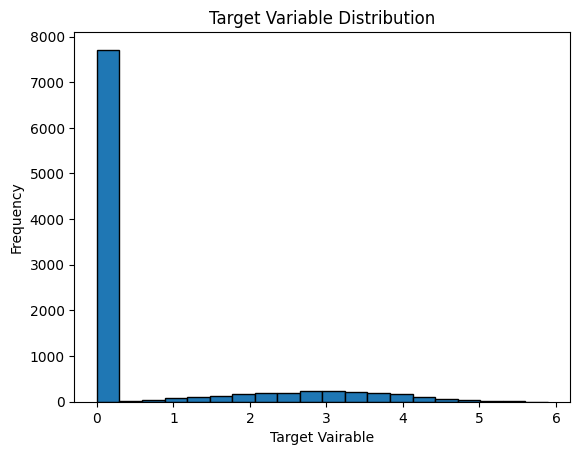

In [155]:
# Lets check the variance
variance = numpy.var(y_train)
print('The Variance - ', variance)

# Visualizing the variance
mat.hist(y_train, bins=20, edgecolor='k')
mat.title('Target Variable Distribution')
mat.xlabel('Target Vairable')
mat.ylabel('Frequency')
mat.show()

In [ ]:
def train_model(xtrain, xtest, ytest, ytrain):

    # Linear Model
    # Training the model
    linearModel = LinearRegression()
    linearModel.fit(xtrain, ytrain)

    # Training data fit
    trainedPrediction = linearModel.predict(xtrain)
    train_rmse = root_mean_squared_error(ytrain, trainedPrediction)
    train_r2 = r2_score(ytrain, trainedPrediction)

    # Test data
    predict = linearModel.predict(xtest)
    test_rmse = root_mean_squared_error(ytest, predict)
    test_r2 = r2_score(ytest, predict)

    # Polynomial Regression
    # Degree Initialization
    degree = [1, 2, 3]
    
    # Score Collectors
    score = {}

    # Y_prediction Variable for plotting
    y_pred = {}

    for eachDegree in degree:
        
        # Training the model
        poly = PolynomialFeatures(degree=eachDegree, include_bias=False)
        x_train_poly = poly.fit_transform(xtrain)
        x_test_poly = poly.transform(xtest)

        poly_reg = LinearRegression()
        poly_reg.fit(x_train_poly, ytrain)

        # Training data fit
        p_train_pred = poly_reg.predict(x_train_poly)
        p_train_rmse = root_mean_squared_error(ytrain, p_train_pred)
        p_train_r2 = r2_score(ytrain, p_train_pred)

        # Test data
        p_predict = poly_reg.predict(x_test_poly)
        p_test_rmse = root_mean_squared_error(ytest, p_predict)
        p_test_r2 = r2_score(ytest, p_predict)

        # Transferring the variables
        y_pred[f'{eachDegree}'] = [p_test_rmse, p_train_rmse]

    # Random Sample Conusensus
    # Parameters for the Random Sample Consencus
    base_model = [LinearRegression(), Lasso()]
    modelNames = ['Linear Model', 'L1 Regularization or Lasso']

    # Residual Threhsold for training and testing
    count = 0

    inlinearAndOutlier = {}

    # Y_pred score
    lassoPredict = []

    for model in base_model:

        xtrain_residualThreshold, xtest_residualThreshold = findResidual(
                model, xtrain, xtest, ytrain, ytest
            )
        
        xtrain_percentile =  numpy.percentile(xtrain_residualThreshold, 90)
        xtest_percentile = numpy.percentile(xtest_residualThreshold, 90)
        
        randomSampleConsencus = RANSACRegressor(
            estimator=model,
            min_samples=0.5,
            residual_threshold=xtrain_percentile,
            max_trials = 10,
            random_state=42
        )

        randomSampleConsencus.fit(xtrain, ytrain)

        # Training Set and Its Score
        rm_train_pred = randomSampleConsencus.predict(xtrain)
        rm_rmse = root_mean_squared_error(ytrain, rm_train_pred)
        rm_r2 = r2_score(ytrain, rm_train_pred)

        # Testing Set and Its score
        rm_test_pred = randomSampleConsencus.predict(xtest)
        rm_test_rmse = root_mean_squared_error(ytest, rm_test_pred)
        rm_test_r2 = r2_score(ytest, rm_test_pred)

        # Transferring the values
        inlineMask = randomSampleConsencus.inlier_mask_
        outlierMask = numpy.logical_not(inlineMask)

        inlinearAndOutlier[modelNames[count]] = {
            'inline_mask': inlineMask,
            'outline_mask': outlierMask
        }

        if modelNames[count] == 'L1 Regularization or Lasso':
            lassoPredict.append([rm_test_rmse, rm_rmse])

        # Range Check Comparison
        rangeCheck(ytest, rm_test_pred)

        count += 1
    
    # Random Forest Regression
    
    # Gradient Boost
    # Preparing the model for the training and testing
    gradientReg = GradientBoostingRegressor(
        max_depth=3,
        min_samples_leaf=13,
        min_samples_split=5,
        max_features='sqrt',
        n_estimators=313,
        random_state=42,
        warm_start=True,
        learning_rate=0.01
    )
    gradientReg.fit(xtrain, ytrain)

    # Training Evaluation
    gtrain_predict = gradientReg.predict(xtrain)
    gtrainrmse = root_mean_squared_error(ytrain, gtrain_predict)
    gtrainr2 = r2_score(ytrain, gtrain_predict)

    # Testing Evaluation
    gtest_predict = gradientReg.predict(xtest)
    gtestrmse = root_mean_squared_error(ytest, gtest_predict)
    gtestr2 = r2_score(ytest, gtest_predict)

    rangeCheck(ytest, gtest_predict)

    # Random Forest Regression
    # Preparing the model
    randomForest = RandomForestRegressor(
        max_depth=5,
        min_samples_leaf=26,
        min_samples_split=17,
        max_features='sqrt',
        n_estimators=453,
        random_state=42,
        warm_start=True
    )

    randomForest.fit(xtrain, ytrain)

    # Training Evaluation
    train_predict = randomForest.predict(xtrain)
    trainrmse = root_mean_squared_error(ytrain, train_predict)
    trainr2 = r2_score(ytrain, train_predict)

    # Testing Evaluation
    test_predict = randomForest.predict(xtest)
    testrmse = root_mean_squared_error(ytest, test_predict)
    testr2 = r2_score(ytest, test_predict)

    dict2 = {
        'Linear Model': [test_rmse, train_rmse],
        'Random Sample Concuses (Lasso Regularization)': lassoPredict[0],
        'Polynomial Regression': y_pred['2'],
        'Random Forest Regression': [testrmse, rm_rmse],
        'Gradient Boost Regression': [gtestrmse, gtrainrmse]
    }
    

    return dict2 

In [162]:
rmseScore = train_model(X_train, X_test, y_test, y_train)

Linear Model 

Trained Prediction Statistics
Train RMSE Score -  0.14791273150979536
Train R2 Score -  0.9863712485945 

Test Prediction Statistics
Test RMSE -  0.14637357839255066
Test r2 -  0.9867311436752554 

Target Range: 5.570217884147302
Test RMSE: 0.14637357839255066
RMSE as % of Target Range: 2.6277890997608218
L1 Regularization or Lasso 

Trained Prediction Statistics
Train RMSE Score -  1.3102146484156272
Train R2 Score -  -0.06937458057970947 

Test Prediction Statistics
Test RMSE -  1.3186497576863738
Test r2 -  -0.07687930231798124 

Target Range: 5.570217884147302
Test RMSE: 1.3186497576863738
RMSE as % of Target Range: 23.67321683123415
Target Range: 5.570217884147302
Test RMSE: 0.1536158683925129
RMSE as % of Target Range: 2.7578071735703507


In [163]:
print('RMSE Score (Root Mean Squared Error)')
training_test_score = pandas.DataFrame.from_dict(rmseScore, orient="index", columns=['TestScore', 'TrainScore'])
training_test_score

RMSE Score (Root Mean Squared Error)


,TestScore,TrainScore
Linear Model,0.143543,0.144270
Random Sample Concuses (Lasso Regularization),1.318650,1.310215
Polynomial Regression,0.037143,0.029355
Random Forest Regression,0.162077,1.310215
Gradient Boost Regression,0.153616,0.155157


In [164]:
# Let's Compare it with the baseline of the dataset
baseline = numpy.full_like(y_test, y_train.mean())
baseline_rmse = float(numpy.sqrt(mean_squared_error(y_test, baseline)))

# Checking this baseline rmse with the rmse score we are getting
for key, values in compData['RMSE'].items():

    if values >= baseline_rmse:
        print(f'{key} underperforms the baseline Mean')
    else:
        print(f'{key} outperforms the baseline Mean,\n\nwhere, \n{key} \nbaseline RMSE - {baseline_rmse} > Model RMSE {values}')
    

Linear Model underperforms the baseline Mean
Random Sample Concuses (Linear Model) underperforms the baseline Mean
Random Sample Concuses (Lasso Regularization) underperforms the baseline Mean
Polynomial Regression underperforms the baseline Mean
Random Forest Regression underperforms the baseline Mean
Gradient Boost Regression underperforms the baseline Mean


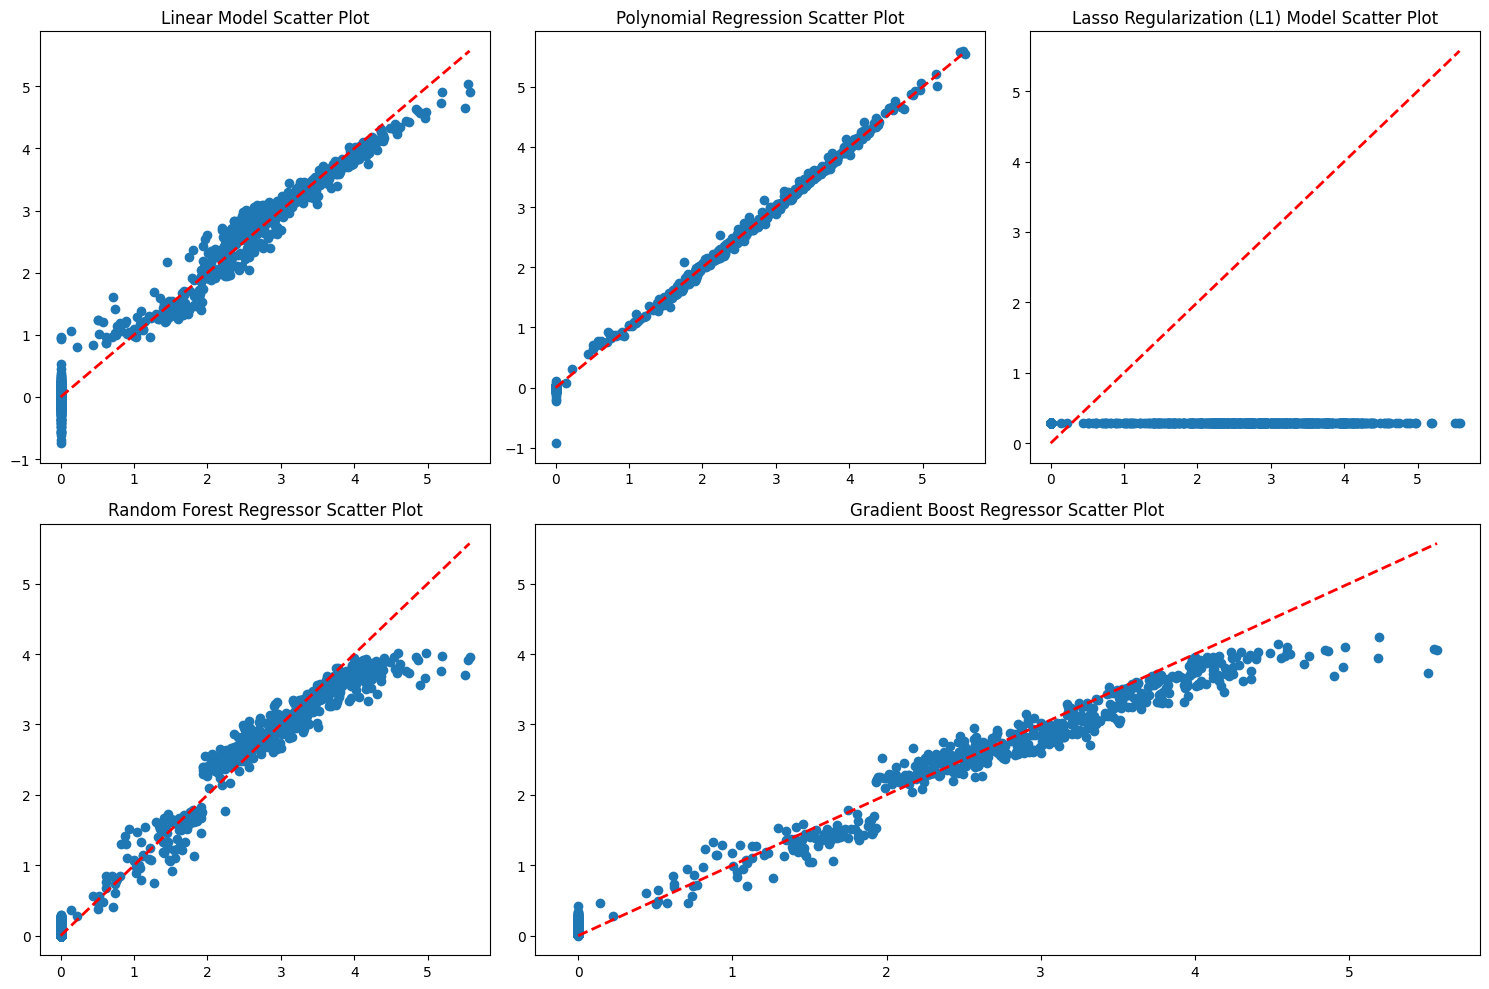

In [166]:
# Let's perform scatter plot analysis for each model

# Linear Model
# Create figure with custom GridSpec layout
fig = mat.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 3)

# Top row
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

# Bottom row: [1, 0] separate, [1, 1] and [1, 2] merged
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1:])

# Scatter plots
ax1.scatter(y_test, predict)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         color='red', linestyle='--', linewidth=2)
ax1.set_title('Linear Model Scatter Plot')

ax2.scatter(y_test, y_pred['2'])
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         color='red', linestyle='--', linewidth=2)
ax2.set_title('Polynomial Regression Scatter Plot')

ax3.scatter(y_test, lassoPredict)
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         color='red', linestyle='--', linewidth=2)
ax3.set_title('Lasso Regularization (L1) Model Scatter Plot')

ax4.scatter(y_test, test_predict)
ax4.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         color='red', linestyle='--', linewidth=2)
ax4.set_title('Random Forest Regressor Scatter Plot')

ax5.scatter(y_test, gtest_predict)
ax5.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         color='red', linestyle='--', linewidth=2)
ax5.set_title('Gradient Boost Regressor Scatter Plot')

mat.tight_layout()
mat.show()